# **Multi-Label Classification Using Neural Network**

### **Import Library**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout

### **Input Dataset**

In [7]:
# Input dataset
dataset_url = 'https://raw.githubusercontent.com/adrielgian99/Bangkit-Capstone-C242-PR593/machine_learning/Clean_Dataset/gym_and_diet_recommendation_clean_dataset.csv'

df = pd.read_csv(dataset_url)

### **Data Preprocessing**

In [8]:
# One-hot encode categorical columns
categorical_columns1 = ["gender", "hypertension_status", "diabetes_status", "fitness_goal", "fitness_type"]
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
onehot_encoded = onehot_encoder.fit_transform(df[categorical_columns1])
onehotencoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns1))

# Concatenate one-hot encoded features with the original DataFrame
df = pd.concat([df, onehotencoded_df], axis=1)

In [9]:
# Label encode categorical columns
label_encoder = {}
categorical_columns2 = ["user_obesity_level", "vegetables", "protein_intake", "juice", "monday_schedule", "tuesday_schedule",
    "wednesday_schedule", "thursday_schedule", "friday_schedule",
    "saturday_schedule", "sunday_schedule"]
for column in categorical_columns2:
    label_encoder[column] = LabelEncoder()  # Create a new LabelEncoder for each column
    df[column] = label_encoder[column].fit_transform(df[column])

In [10]:
# Normalize numerical columns
scaler = MinMaxScaler()
df[['age', 'height', 'weight', 'BMI']] = scaler.fit_transform(df[['age', 'height', 'weight', 'BMI']])

### **Modeling**

In [11]:
# Select input and output columns
input_columns = [
    "age", "height", "weight", "BMI", "user_obesity_level"
] + onehotencoded_df.columns.tolist()
output_columns = [
    "vegetables", "protein_intake", "juice", "monday_schedule", "tuesday_schedule",
    "wednesday_schedule", "thursday_schedule", "friday_schedule",
    "saturday_schedule", "sunday_schedule"
]

In [12]:
# Separate features and target
X = df[input_columns]
y = df[output_columns]

# Show X and y shape
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (14552, 15)
Shape of y: (14552, 10)


In [13]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Check the processed data shapes
{
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape
}

{'X_train_shape': (11641, 15),
 'X_test_shape': (2911, 15),
 'y_train_shape': (11641, 10),
 'y_test_shape': (2911, 10)}

In [24]:
# Build the model
input_layer = Input(shape=(X_train.shape[1],))

# Build the neural network model
x = Dense(256, activation='relu')(input_layer)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

# Adjust output layers
output_layers = {}
for col in output_columns:
    num_classes = len(df[col].unique())
    output_layers[col] = Dense(num_classes, activation='softmax', name=col)(x)

# Compile the model
model = Model(inputs=input_layer, outputs=list(output_layers.values()))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=[['accuracy'] for _ in range(len(output_columns))])

# Summary of the model
model_summary = model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │          4,096 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │        131,584 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 512)            │        262,656 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vegetables (Dense)        │ (None, 9)              │          4,617 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ protein_intake (Dense)    │ (None, 9)              │          4,617 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ juice (Dense)             │ (None, 5)              │          2,565 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ monday_schedule (Dense)   │ (None, 3)              │          1,539 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tuesday_schedule (Dense)  │ (None, 3)              │          1,539 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wednesday_schedule        │ (None, 1)              │            513 │ dense_8[0][0]          │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ thursday_schedule (Dense) │ (None, 3)              │          1,539 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ friday_schedule (Dense)   │ (None, 5)              │          2,565 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ saturday_schedule (Dense) │ (None, 5)              │          2,565 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sunday_schedule (Dense)   │ (None, 1)              │            513 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 420,908 (1.61 MB)

 Trainable params: 420,908 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Training Model**

In [25]:
history = model.fit(
    X_train,
    [y_train.iloc[:, i].values for i in range(y_train.shape[1])],
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - friday_schedule_accuracy: 0.8985 - friday_schedule_loss: 0.3478 - juice_accuracy: 0.7980 - juice_loss: 0.6293 - loss: 3.7361 - monday_schedule_accuracy: 0.9341 - monday_schedule_loss: 0.2153 - protein_intake_accuracy: 0.7479 - protein_intake_loss: 0.8821 - saturday_schedule_accuracy: 0.8855 - saturday_schedule_loss: 0.3574 - sunday_schedule_accuracy: 0.0000e+00 - sunday_schedule_loss: 0.0000e+00 - thursday_schedule_accuracy: 0.9322 - thursday_schedule_loss: 0.1713 - tuesday_schedule_accuracy: 0.8893 - tuesday_schedule_loss: 0.2422 - vegetables_accuracy: 0.7521 - vegetables_loss: 0.8906 - wednesday_schedule_accuracy: 0.0000e+00 - wednesday_schedule_loss: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


291/291 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - friday_schedule_accuracy: 0.8988 - friday_schedule_loss: 0.3470 - juice_accuracy: 0.7984 - juice_loss: 0.6286 - loss: 3.7302 - monday_schedule_accuracy: 0.9343 - monday_schedule_loss: 0.2148 - protein_intake_accuracy: 0.7483 - protein_intake_loss: 0.8811 - saturday_schedule_accuracy: 0.8858 - saturday_schedule_loss: 0.3566 - sunday_schedule_accuracy: 0.0000e+00 - sunday_schedule_loss: 0.0000e+00 - thursday_schedule_accuracy: 0.9324 - thursday_schedule_loss: 0.1710 - tuesday_schedule_accuracy: 0.8895 - tuesday_schedule_loss: 0.2417 - vegetables_accuracy: 0.7525 - vegetables_loss: 0.8895 - wednesday_schedule_accuracy: 0.0000e+00 - wednesday_schedule_loss: 0.0000e+00 - val_friday_schedule_accuracy: 0.9966 - val_friday_schedule_loss: 0.0236 - val_juice_accuracy: 0.9498 - val_juice_loss: 0.2445 - val_loss: 1.0401 - val_monday_schedule_accuracy: 0.9966 - val_monday_schedule_loss: 0.0239 - val_protein_intake_accuracy: 0.9360 - val_protein_intake_los

### **Evaluation Model**

In [26]:
# Evaluate the model
evaluation = model.evaluate(X_test, [y_test.iloc[:, i].values for i in range(y_test.shape[1])])

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - friday_schedule_accuracy: 0.9965 - friday_schedule_loss: 0.0165 - juice_accuracy: 0.9386 - juice_loss: 0.1985 - loss: 0.8324 - monday_schedule_accuracy: 0.9961 - monday_schedule_loss: 0.0168 - protein_intake_accuracy: 0.9227 - protein_intake_loss: 0.2746 - saturday_schedule_accuracy: 0.9965 - saturday_schedule_loss: 0.0176 - sunday_schedule_accuracy: 0.0000e+00 - sunday_schedule_loss: 0.0000e+00 - thursday_schedule_accuracy: 0.9965 - thursday_schedule_loss: 0.0185 - tuesday_schedule_accuracy: 0.9970 - tuesday_schedule_loss: 0.0153 - vegetables_accuracy: 0.9245 - vegetables_loss: 0.2746 - wednesday_schedule_accuracy: 0.0000e+00 - wednesday_schedule_loss: 0.0000e+00


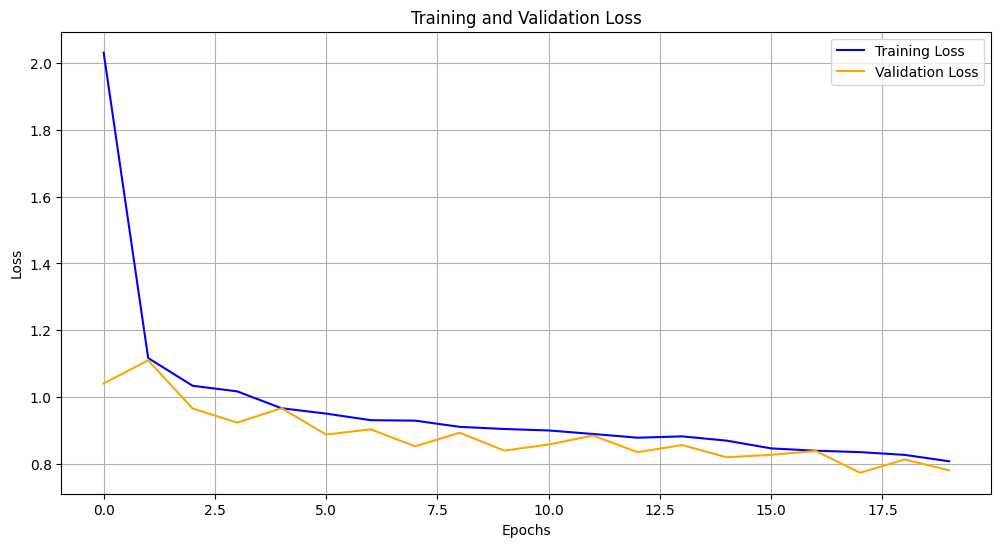

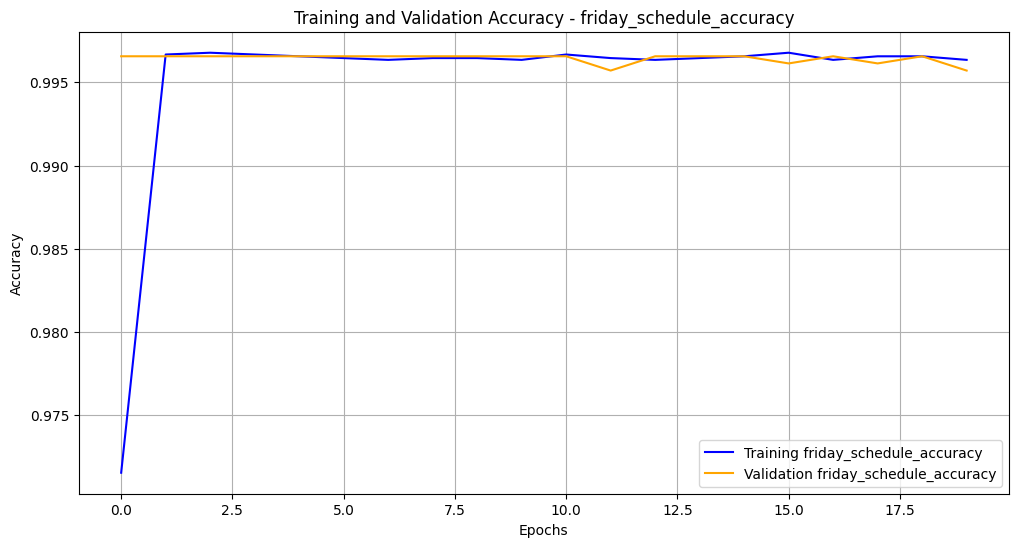

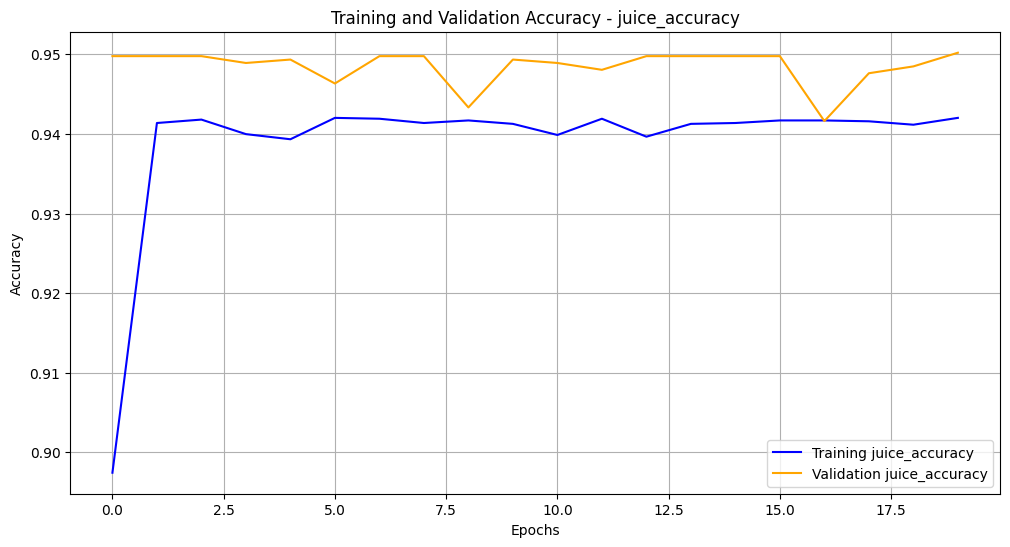

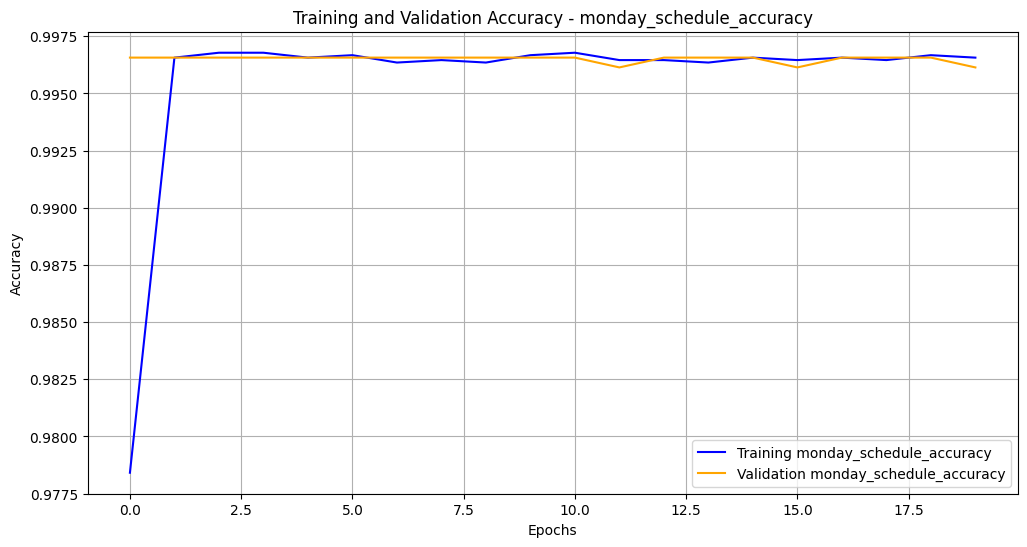

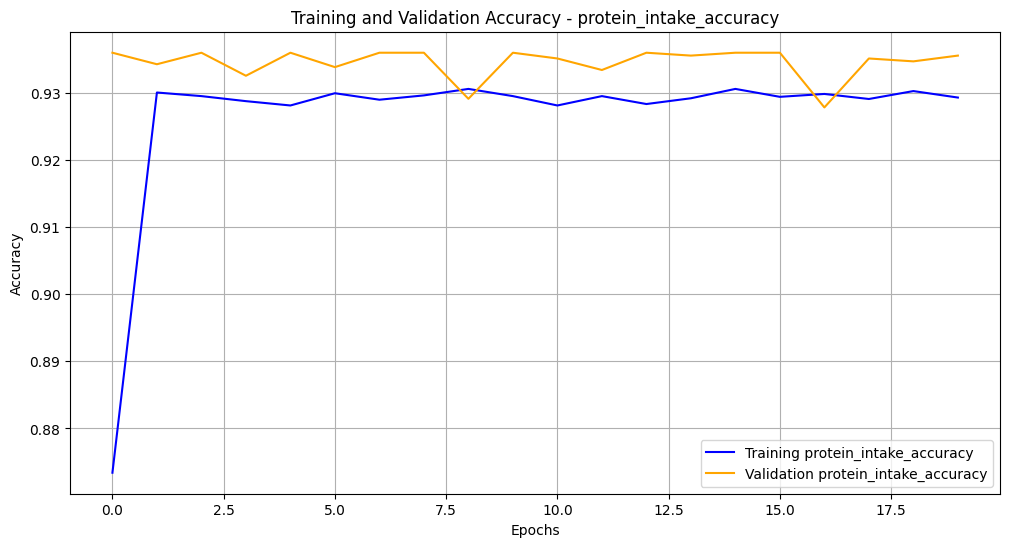

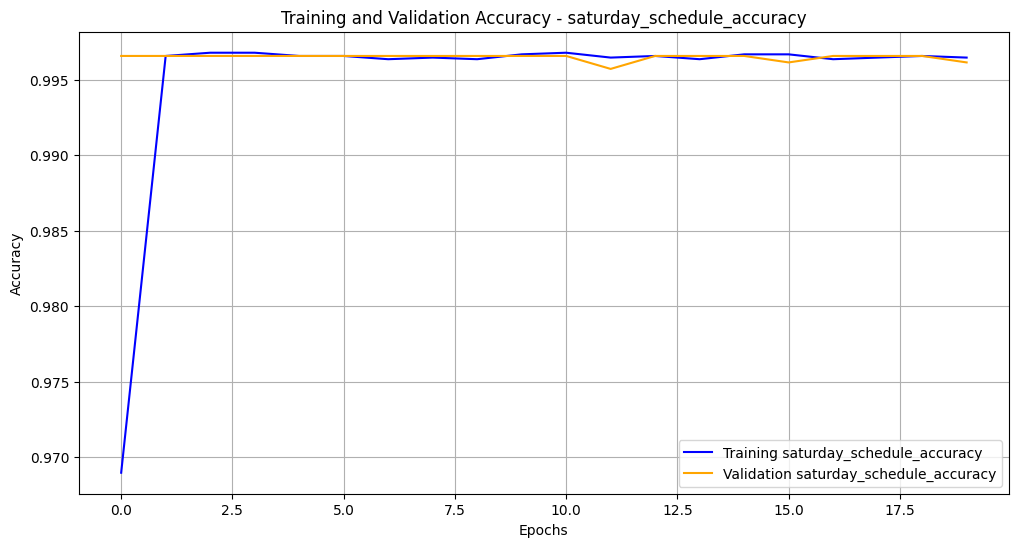

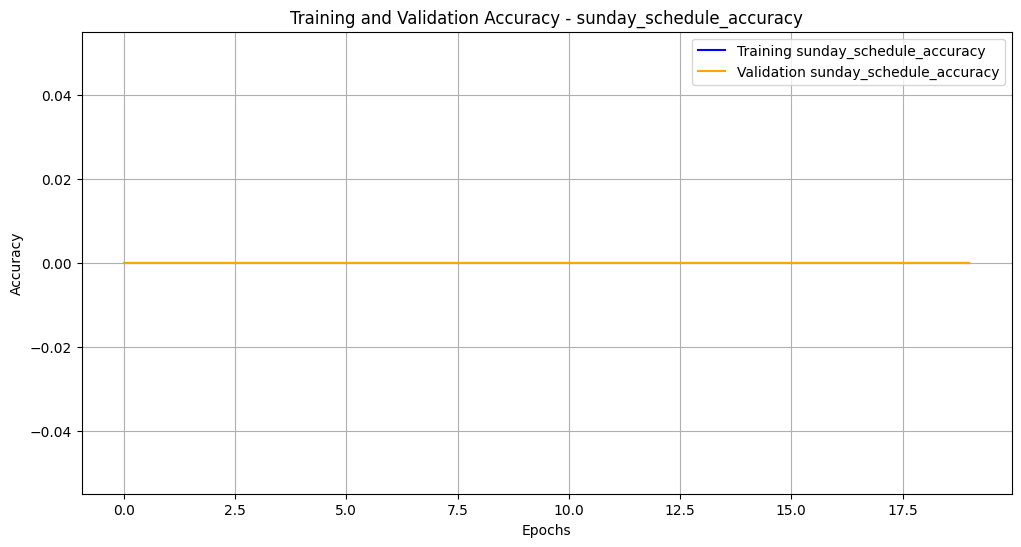

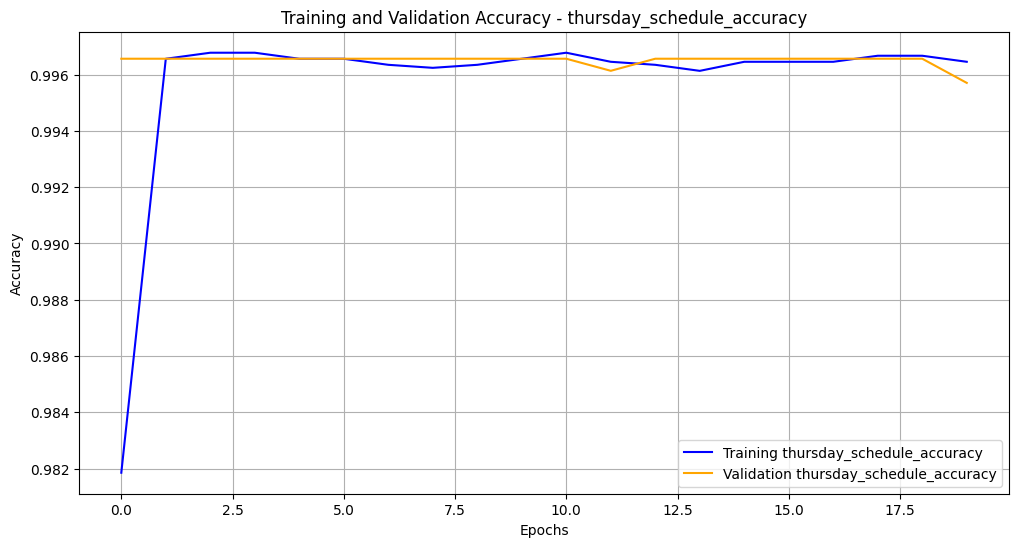

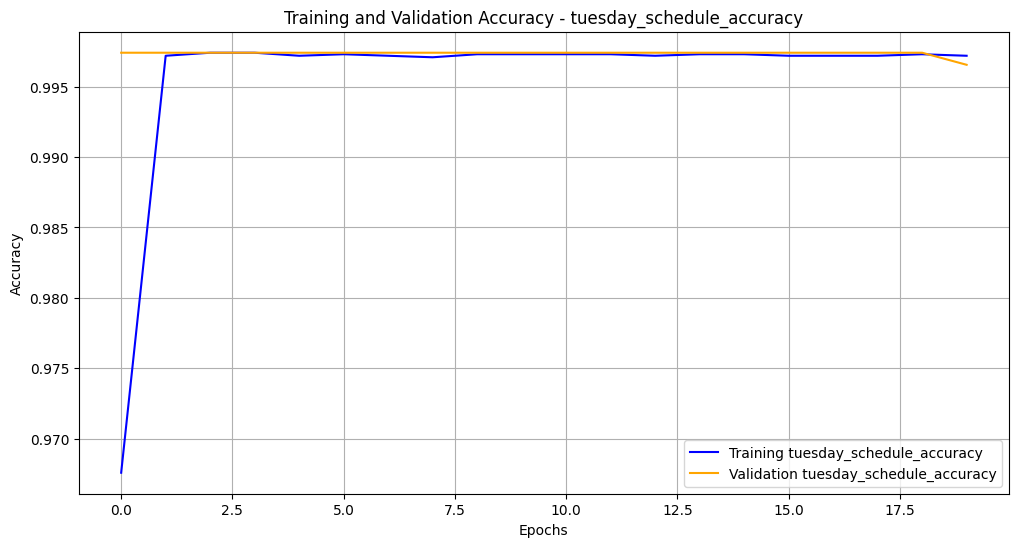

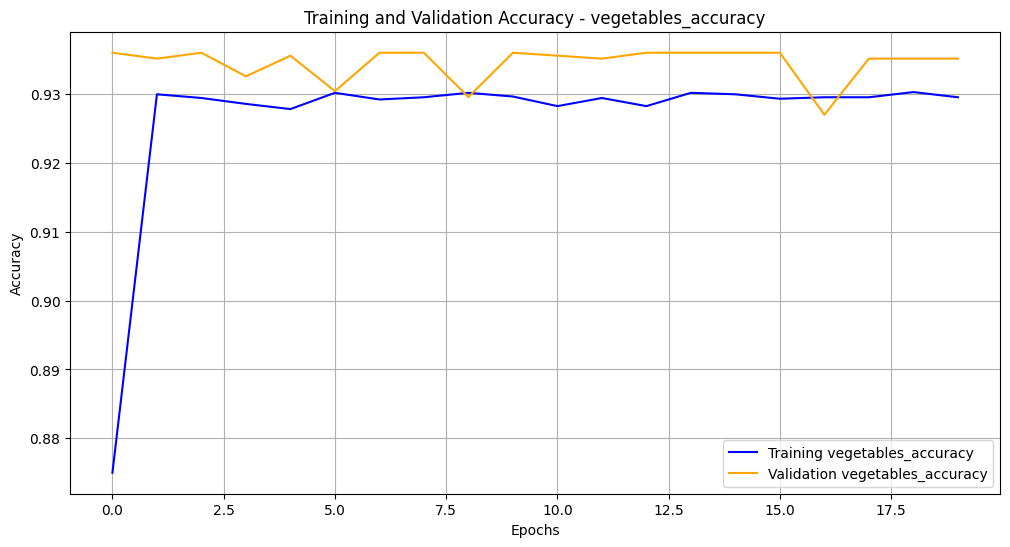

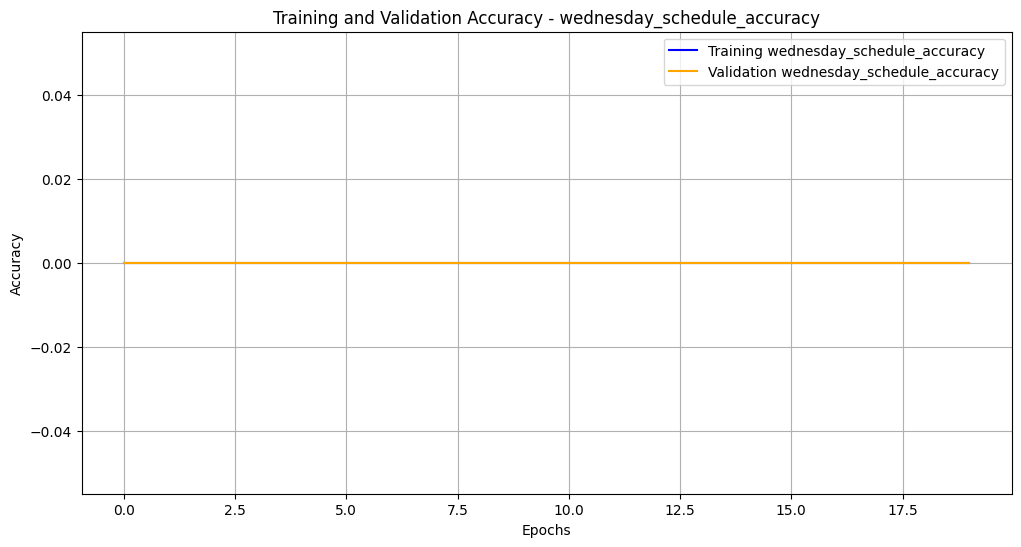

In [27]:
# Take data from history
history_dict = history.history

# Loss Graph
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy Graph (each output)
output_columns_graph = [col for col in history_dict.keys() if 'accuracy' in col and 'val_' not in col]
for output in output_columns_graph:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict[output], label=f'Training {output}', color='blue')
    plt.plot(history_dict[f'val_{output}'], label=f'Validation {output}', color='orange')
    plt.title(f'Training and Validation Accuracy - {output}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

### **Save Model and Preprocessor**

In [28]:
# Save the model
model.save('gym_and_diet_model.h5')

### **Convert Model**

In [87]:
# Install tensorflowjs
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [29]:
!tensorflowjs_converter --input_format=keras \
gym_and_diet_model.h5 \
./tfjs_model

2024-12-07 05:13:37.591825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733548417.621754   16641 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733548417.630617   16641 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


### **Example Prediction**

In [30]:
# Load the trained model
model = load_model('gym_and_diet_model.h5')

# Example new data for prediction
new_data = pd.DataFrame({
    'gender': ['pria'],
    'age': [22],
    'height': [170],
    'weight': [95.0],
    'BMI': [32.90],
    'hypertension_status': ['tidak'],
    'diabetes_status': ['tidak'],
    'user_obesity_level': ['Obesity_Type_I'],
    'fitness_goal': ['Weight Loss'],
    'fitness_type': ['Cardio Fitness']
})

# Preprocess the new data
# One-hot encode categorical columns
categorical_columns1 = ["gender", "hypertension_status", "diabetes_status", "fitness_goal", "fitness_type"]
new_data_encoded = onehot_encoder.transform(new_data[categorical_columns1])  # Use the previously fitted encoder
new_data_encoded_df = pd.DataFrame(new_data_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns1))
new_data = pd.concat([new_data, new_data_encoded_df], axis=1)

# Label encode categorical columns
new_data["user_obesity_level"] = label_encoder["user_obesity_level"].transform(new_data["user_obesity_level"])  # Use the previously fitted encoder

# Normalize numerical columns
new_data[['age', 'height', 'weight', 'BMI']] = scaler.transform(new_data[['age', 'height', 'weight', 'BMI']])  # Use the previously fitted scaler

# Select features for prediction
X_new = new_data[input_columns]

# Predict the outputs
predictions = model.predict(X_new)

decoded_predictions = {}
for i, output in enumerate(output_columns):
    # Use the encoder specific to the current output column for inverse transform
    decoded_predictions[output] = label_encoder[output].inverse_transform([np.argmax(predictions[i])])[0]

# Print predictions
for key, value in decoded_predictions.items():
    print(f"{key}: {value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


vegetables: brokoli, wortel, bayam, selada, bawang bombai
protein_intake: keju, keju cottage, susu skim, susu rendah lemak, kacang tanah
juice: jus buah, jus lidah buaya, jus cold pressed, jus semangka
monday_schedule: jalan cepat (30 menit)
tuesday_schedule: bersepeda (30 menit)
wednesday_schedule: istirahat
thursday_schedule: berenang (20 menit)
friday_schedule: lari (20 menit)
saturday_schedule: senam (30 menit)
sunday_schedule: istirahat
